# Import

In [ ]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [ ]:
# common
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

In [ ]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [ ]:
# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

# Data load

In [ ]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

In [ ]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

def show_contour(image, mask, contour ,cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.imshow(tf.squeeze(contour), cmap=cmap, alpha=0.6)
    plt.axis('off')


def only_mask(mask, cmap=None, alpha=1):
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [ ]:
SIZE = 256

root_path = '/content/drive/MyDrive/Breast_cacer_Unet/Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes

['.ipynb_checkpoints', 'benign', 'malignant', 'normal']

In [ ]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

In [ ]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

# 학습용 컨투어 처리 이미지 만들기

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

font = cv2.FONT_HERSHEY_SIMPLEX
number = 0

for i in mask_paths:
  path = i 
  img_color = cv2.imread(path, cv2.IMREAD_COLOR)
  gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
  ret, img_binary = cv2.threshold(gray, 127, 255, 0)
  contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  
  for cnt in contours:
    area=cv2.contourArea(cnt)
    print(area)
    x,y,w,h = cv2.boundingRect(cnt)
    
    # 면적 아닌 원 둘레값으로 원의 지름값으로 나눠서 라벨링해야함
    if area < 45000:
      cv2.rectangle(img_color,(x,y),(x+w,y+h),(0,0,255),2) #blue
      cv2.putText(img_color,'T1',(x,y-5), font, .5,(255,255,255),1,8)
      
    elif area > 45000:
      cv2.rectangle(img_color,(x,y),(x+w,y+h),(255,0,255),2) #pink
      cv2.putText(img_color,'T2',(x,y-5), font, .5,(255,255,255),1,8)
    os.chdir('/content/drive/MyDrive/Breast_cacer_Unet/contours/')
    cv2.imwrite('contour(' + str(number) + ').png', img_color) #이미지 파일 저장
    number += 1
cv2.waitKey(0)
clear_output()

# 샘플 이미지 확인

In [ ]:
len(image_paths)

780

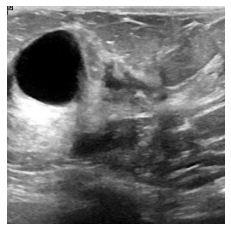

In [ ]:
show_image(load_image(image_paths[1], SIZE))

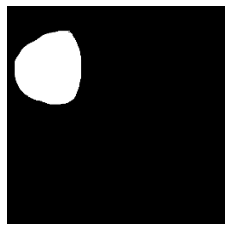

In [ ]:
show_image(load_image(mask_paths[1], SIZE))

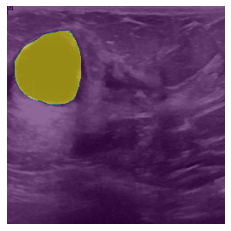

In [ ]:
show_mask(load_image(image_paths[1], SIZE), load_image(mask_paths[1], SIZE)[:,:,0], alpha=0.6)

In [ ]:
contour_path = '/content/drive/MyDrive/Breast_cacer_Unet/contours/'
contour_path = sorted(os.listdir(contour_path))

In [ ]:
show_contour(load_image(image_paths[1], SIZE), load_image(mask_paths[1], SIZE)[:,:,0], load_image(contour_path[0], SIZE)[:,:,0], alpha=0.6)

# Approach

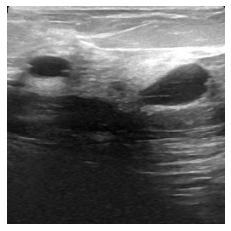

In [ ]:
show_image(load_image('/content/drive/MyDrive/Breast_cacer_Unet/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))

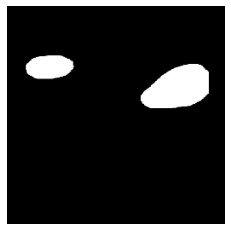

In [ ]:
img = np.zeros((1,SIZE,SIZE,3))
mask1 = load_image('/content/drive/MyDrive/Breast_cacer_Unet/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png', SIZE)
mask2 = load_image('/content/drive/MyDrive/Breast_cacer_Unet/Dataset_BUSI_with_GT/benign/benign (100)_mask.png', SIZE)

img = img + mask1 + mask2
img = img[0,:,:,0]
show_image(img, cmap='gray')

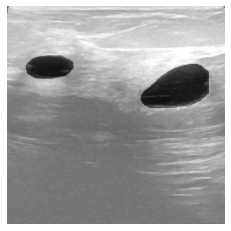

In [ ]:
show_image(load_image('/content/drive/MyDrive/Breast_cacer_Unet/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, cmap='binary', alpha=0.4)
plt.axis('off')
plt.show()

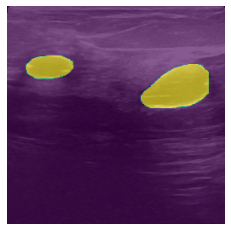

In [ ]:
show_image(load_image('/content/drive/MyDrive/Breast_cacer_Unet/Dataset_BUSI_with_GT/benign/benign (100).png', SIZE))
plt.imshow(img, alpha=0.65)
plt.axis('off')
plt.show()

# Data Work

In [ ]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

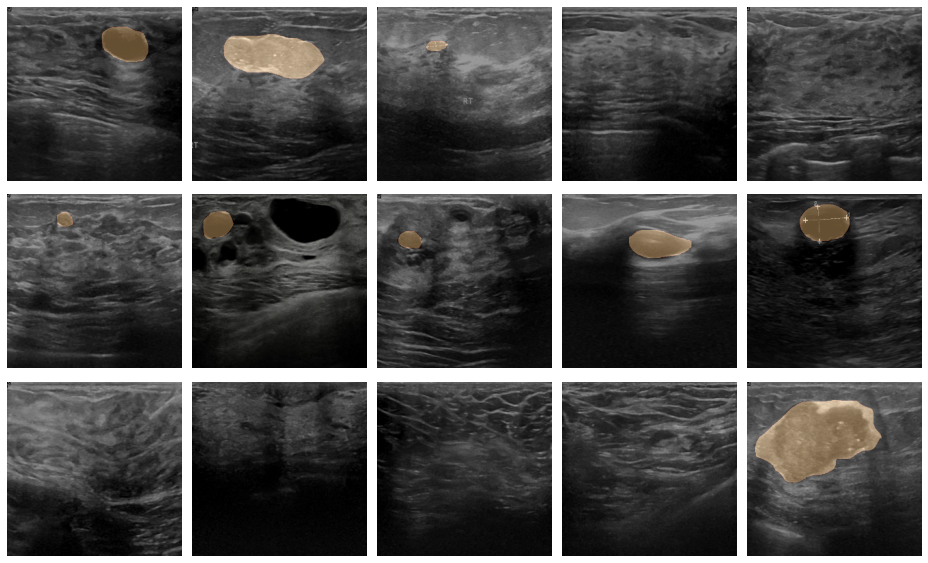

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper')
plt.tight_layout()
plt.show()

# Encoder

In [ ]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# Decoder

In [ ]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# Attention Gate

In [ ]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

# Custom Callback

In [ ]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(200)
        exp = GradCAM()
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(10,5))

        plt.subplot(1,3,1)
        plt.title("Original Mask")
        show_mask(image, mask, cmap='copper')

        plt.subplot(1,3,2)
        plt.title("Predicted Mask")
        show_mask(image, pred_mask, cmap='copper')

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

# Attention UNet

In [ ]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

In [ ]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output 
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

# Compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')]
)
model.summary()

# Callbacks
cb = [
    # EarlyStopping(patience=3, restore_best_weight=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Encoder1 (EncoderBlock)        ((None, 128, 128, 3  10144       ['input_1[0][0]']                
                                2),                                                               
                                 (None, 256, 256, 3                                               
                                2))                                                               
                                                                                              

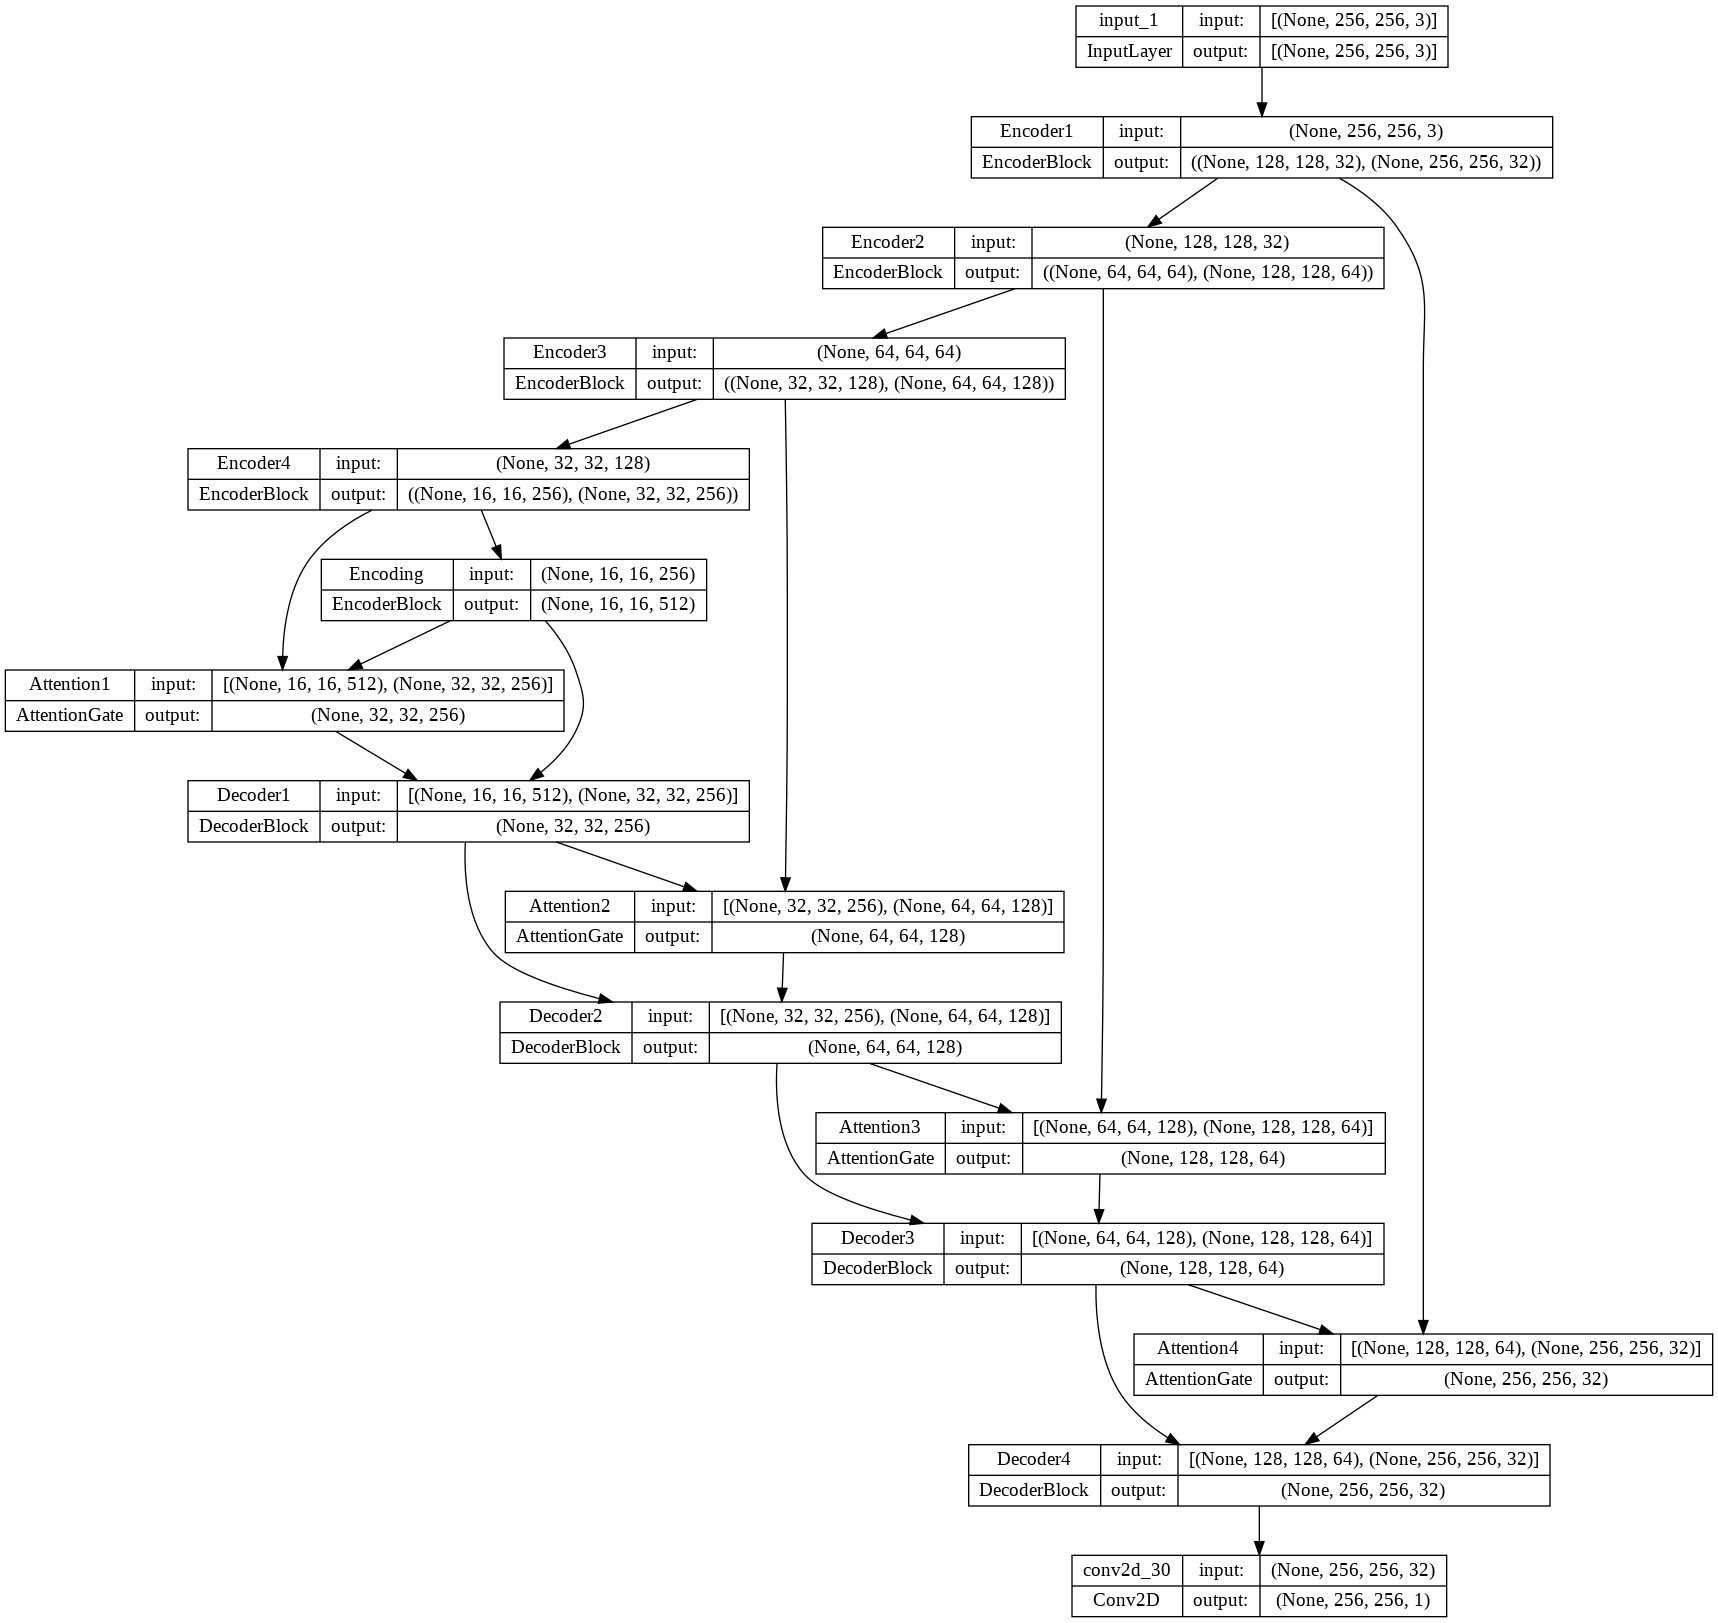

In [ ]:
keras.utils.plot_model(model, show_shapes = True)

In [ ]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

inputs = Input(shape=images.shape[-3:])
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(32, 3, activation='relu', strides = 1, padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(32, 3, activation='relu', strides = 1, padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D()(c1)

c2 = tf.keras.layers.Conv2D(64, 3, activation='relu', strides = 1, padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, 3, activation='relu', strides = 1, padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D()(c2)
 
c3 = tf.keras.layers.Conv2D(128, 3, activation='relu', strides = 1, padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, 3, activation='relu', strides = 1, padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D()(c3)
 
c4 = tf.keras.layers.Conv2D(256, 3, activation='relu', strides = 1, padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, 3, activation='relu', strides = 1, padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D()(c4)
 
c5 = tf.keras.layers.Conv2D(512, 3, activation='relu', strides = 1, padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(512, 3, activation='relu', strides = 1, padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(256, 2,strides=2, padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, 3, activation='relu', strides = 1, padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, 3, activation='relu', strides = 1, padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, 3, activation='relu', strides = 1, padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(128, 3, activation='relu', strides = 1, padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, 3, activation='relu', strides = 1, padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64, 3, activation='relu', strides = 1, padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, 3,name="Attention4", activation='relu', strides = 1, padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, 3, activation='relu', strides = 1, padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1),padding='same', activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')])

cb = [
    # EarlyStopping(patience=3, restore_best_weight=True), # With Segmentation I trust on eyes rather than on metrics
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

model.summary()

# Training

In [ ]:
# Config Training
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

# Training
results = model.fit(
    images, masks,
    validation_split=0.2,
    epochs= 100, # 15 will be enough for a good Model for better model go with 20+
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
    callbacks=cb
)

# Evaluation

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

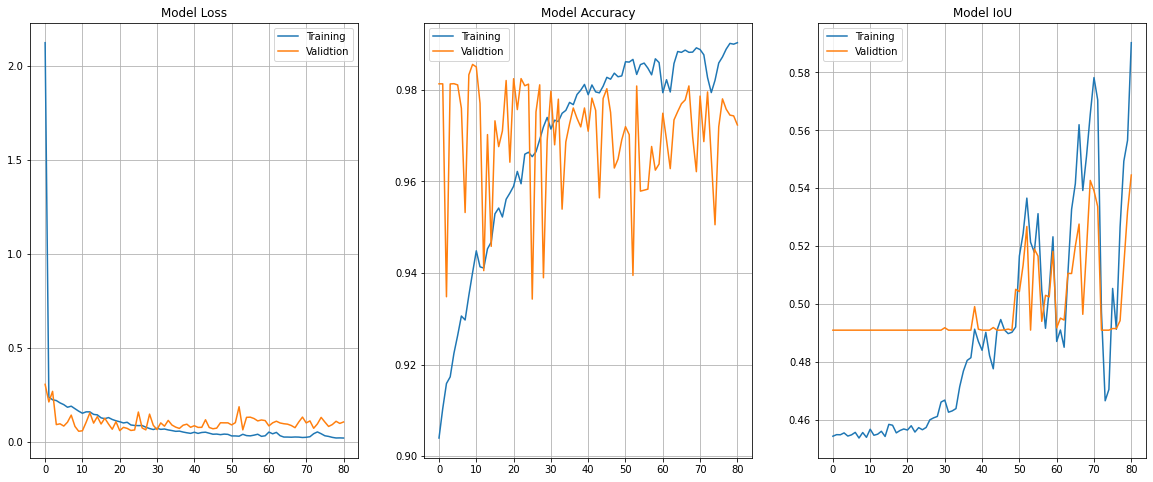

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

1/1 [==============================] - 0s 18ms/step


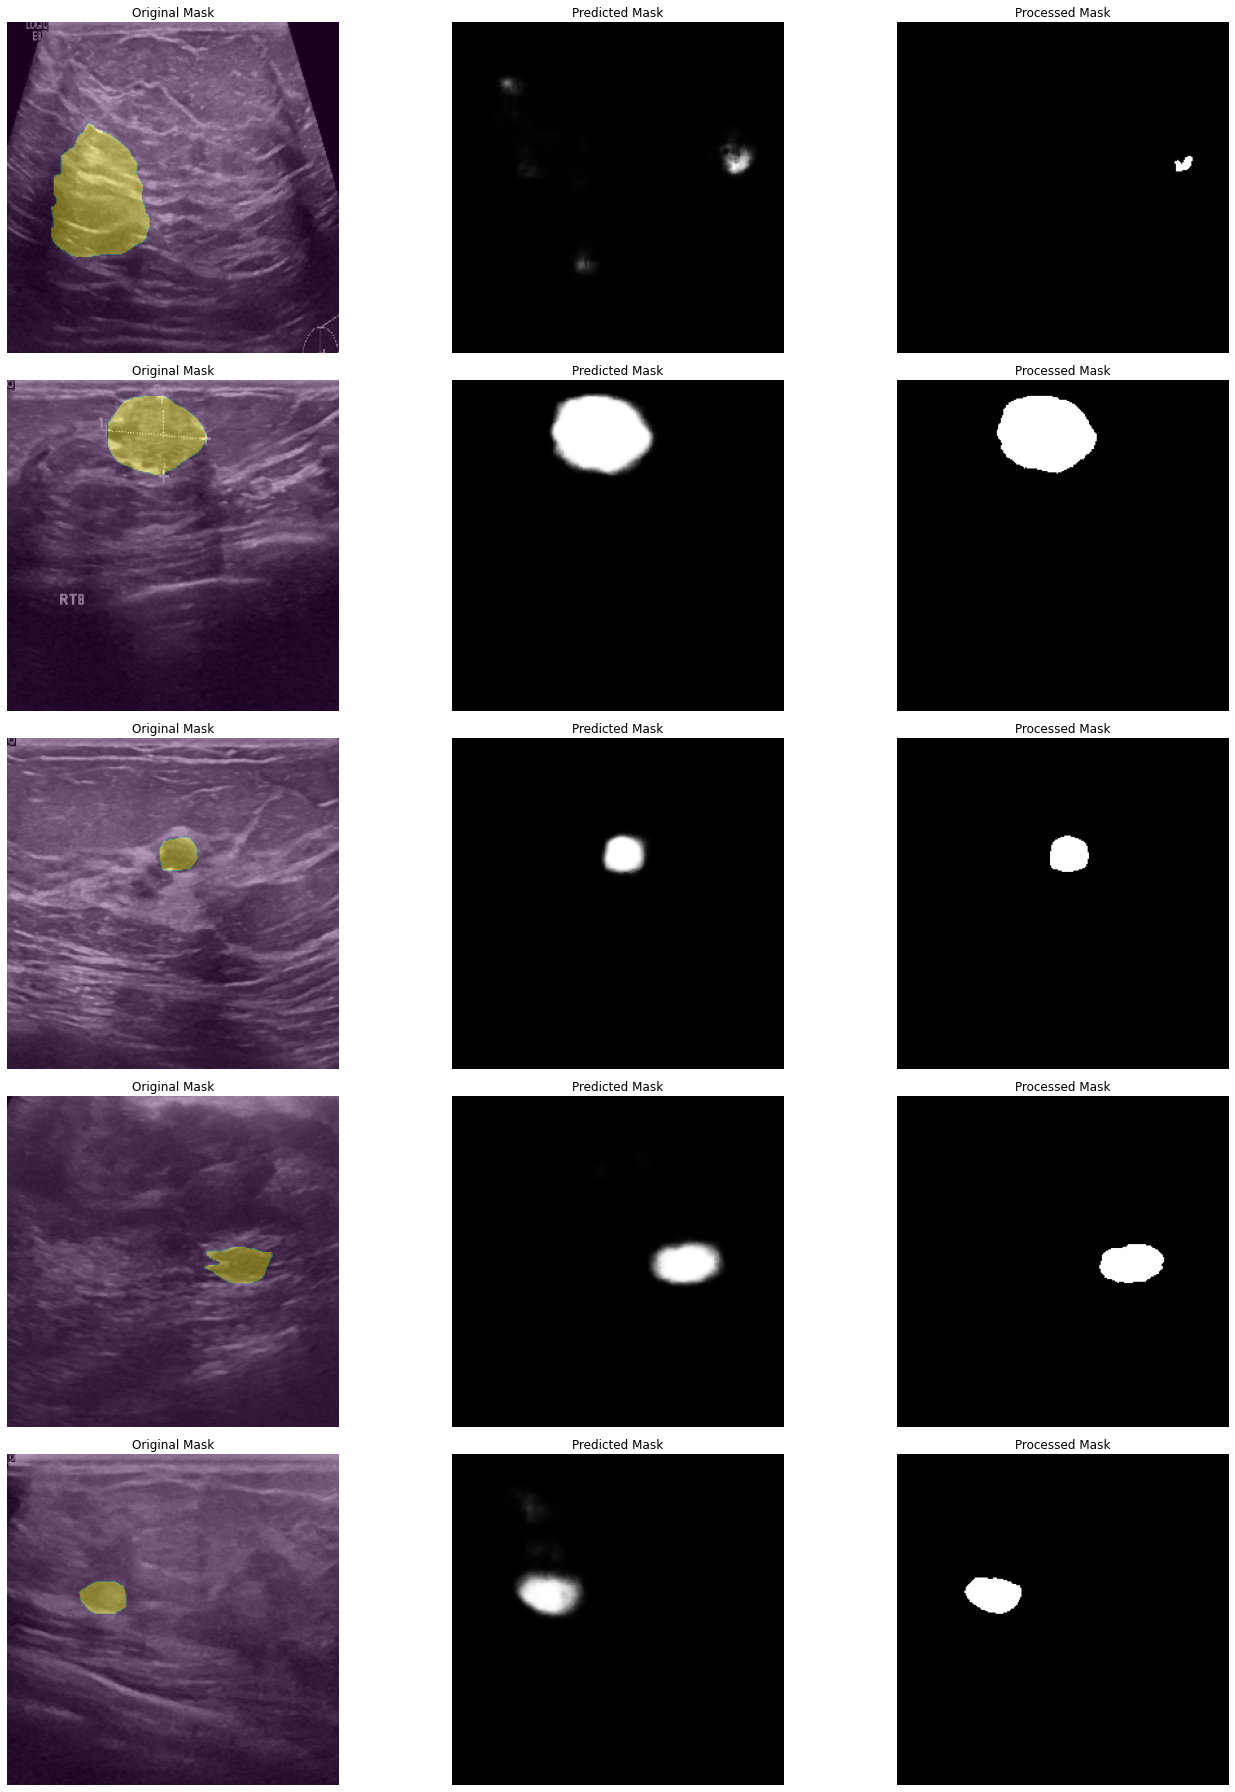

In [ ]:
plt.figure(figsize=(20,25))
n=0
for i in range(1,(5*3)+1):
    plt.subplot(5,3,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])

        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        plt.title("Predicted Mask")
        only_mask(pred_mask, cmap="gray")
        n+=1
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        plt.title("Processed Mask")
        only_mask(pred_mask, cmap="gray")
        n=0
plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

contour_path = '/content/drive/MyDrive/Breast_cacer_Unet/pred_mask'
contour_path = sorted(os.listdir(contour_path))
contour_path

['추론_1.PNG', '추론_2.PNG', '추론_3.PNG']

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
number = 0

for i in contour_path:
  path = i 
  img_color = cv2.imread(path, cv2.IMREAD_COLOR)
  gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
  ret, img_binary = cv2.threshold(gray, 127, 255, 0)
  contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  
  for cnt in contours:
    area=cv2.contourArea(cnt)
    print(area)
    x,y,w,h = cv2.boundingRect(cnt)
    
    # 면적 아닌 원 둘레값으로 원의 지름값으로 나눠서 라벨링해야함
    if area < 45000:
      cv2.rectangle(img_color,(x,y),(x+w,y+h),(0,0,255),2) #blue
      cv2.putText(img_color,'T1',(x,y-5), font, .5,(255,255,255),1,8)
      
    elif area > 45000:
      cv2.rectangle(img_color,(x,y),(x+w,y+h),(255,0,255),2) #pink
      cv2.putText(img_color,'T2',(x,y-5), font, .5,(255,255,255),1,8)
    os.chdir('/content/drive/MyDrive/Breast_cacer_Unet/pred_contours')
    cv2.imwrite('contour(' + str(number) + ').png', img_color) #이미지 파일 저장
    number += 1
cv2.waitKey(0)
clear_output()